# Script para geração de planilha de atividades para o SisDGF

Projeto: Instrução de processos de controle externo próprios da competência da Coordenadoria de Controle de Decisões.
Tarefa: Relatório #12125 Registrar as informações básicas para a identificação dos autos processuais e dos encaminhamentos propostos.


In [59]:
import pypdf
import datetime

import pandas as pd

from pathlib import Path
from functools import partial
from langchain_openai import  AzureChatOpenAI
from langchain.prompts import PromptTemplate
from utils_ccd import get_connection, get_info_file_path

conn = get_connection()

In [2]:
def extract_text_from_pdf(file_path):
    try:
        with open(file_path, 'rb') as f:
            reader = pypdf.PdfReader(f)
            text = ''
            for page in reader.pages:
                text += page.extract_text() or ''
            return text
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ''
    
def get_next_informacao(processo, df_last, df_informacoes):
    try:
        evento = df_last[df_last['processo'] == \
                                         processo]['evento'].iloc[0]
        return df_informacoes[(df_informacoes.evento > \
                                      evento) & \
                                        (df_informacoes['processo'] == \
                                         processo)].sort_values(by='evento').iloc[0]
    except IndexError:
        return None

def get_text_next_informacao(processo, df_last, df_informacoes):
    info = get_next_informacao(processo, df_last, df_informacoes)
    if info is not None:
        return extract_text_from_pdf(info['caminho_arquivo'])
    return ''

llm = AzureChatOpenAI(model_name="gpt-4o")

def get_descricao_objeto_ccd(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa e resume informações de processos do Tribunal de Contas do Estado do Rio Grande do Norte.

        O texto da informação é o seguinte:
        "{input}"
                                              
        Defina a Descrição resumida do objeto/assunto principal. A descrição deve estar em uma das categorias abaixo:
                                              
        Baixa de responsabilidade por prescrição
        Atualização do CADINQ
        Implantação de débito de desconto em folha
        Instauração de Processo de Execução
        Encaminhamento ao Ministério Público para Inscrição em Dívida Ativa
        Encaminhamento ao Ministério Público
        Encaminhamento para Protesto
        Análise de Antecedentes
        Cancelamento de Débito
        Cancelamento de Parcelamento
        Reabertura de Parcelamento
        Retorno de protesto
                                              
        Outros assuntos: <Descrição> 
                                        
        Utilize somente essas categorias. Tente sempre encaixar na categoria existente.
        Não crie novas categorias ou use outras descrições.
        Se não houver uma descrição adequada, responda "Outros assuntos: <Descrição>", e
        substituia <Descrição> pela descrição.                                             

        Sua resposta:
        """)

        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None

def get_descricao_objeto_cip(texto):
    # Colunas tipo de processo, tipo de informação, último item ementa
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa e resume informações de processos do Tribunal de Contas do Estado do Rio Grande do Norte.

        O texto da informação é o seguinte:
        "{input}"
        Defina a Descrição resumida do objeto/assunto principal. 
        Seja sucinto e claro, não é necessário mencionar valores ou números de processos ou leis.
        Deve ser uma frase com no máximo 7 palavras, sem muitos detalhes.
        
        Antes da descrição, coloque a categoria do objeto, que pode ser uma das seguintes:
        Defesa
        Informação Conclusiva
        Informação Instrutiva
        Recurso
                                              
        Sua resposta no formato "Categoria - Descrição":
                                              
        """)

        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    
def get_descricao_encaminhamento(texto, proximo_texto, cip=False):
    if not proximo_texto and not cip:
        return f'Nenhum encaminhamento até o momento {datetime.datetime.now().strftime("%d/%m/%Y")}'
    try:
        if not cip:
            prompt = PromptTemplate.from_template("""
            Você é um agente que analisa encaminhamentos. A informação é sobre um 
            processo do Tribunal de Contas do Estado do Rio Grande do Norte.
            
            O texto da primeira informação é o seguinte:
            "{texto}"

            Depois veio a seguinte informação de encaminhamento:                                      
            "{proximo_texto}"
                                                
            Seja sucinto e claro, não é necessário mencionar valores ou números de processos ou leis.
            Deve ser uma frase ou duas, sem muitos detalhes.
                                                
            Por exemplo: 
                Encaminhamento do Ministério Público à Procuradoria Geral do Estado.
                
            Sua resposta:
            """)
        else:
            prompt = PromptTemplate.from_template("""
            Você é um agente que analisa encaminhamentos. A informação é sobre um 
            processo do Tribunal de Contas do Estado do Rio Grande do Norte.
            
            O texto da informação é o seguinte:
            "{texto}"

            Identifique na informação o encaminhamento do processo.                        
            Seja sucinto e claro, não é necessário mencionar valores ou números de processos ou leis.
            Deve ser uma frase ou duas, sem muitos detalhes.
                                                
            Por exemplo: 
                Encaminhamento do Ministério Público à Procuradoria Geral do Estado.
                                                
            Sua resposta:
            """)

        chain = prompt | llm
        msg_obj = chain.invoke({"texto":texto, "proximo_texto":proximo_texto})
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    
def get_informacao_ementa_resumo(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa informações de processos do Tribunal de Contas do Estado do Rio Grande do Norte.
        As informações possuem ementas. Após a ementa, há um resumo do texto.
        O resumo são 4 ou 3 parágrafos ou linhas, logo após a ementa.
                                              
        O resumo fica entre a ementa e o texto da informação, 
        
        O texto da informação inicia com INFORMAÇÃO e deve ser ignorado.                                      

        Sua tarefa é extrair o resumo que fica após a ementa da informação e até o início do texto da informação.                                       

        O texto da informação é o seguinte:
        "{input}"
                                              
        Somente extraia o texto, não modifique ou adicione nada.
        Se não houver ementa ou resumo, responda "Nenhum resumo encontrado".
        Separe o resumo por parágrafos, se houver mais de um, com \n (quebra de linha) entre eles.                                              
        
        Sua resposta:
        """)
        
        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    
def get_conclusao(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa informações de processos do Tribunal de Contas do Estado do Rio Grande do Norte.
        Um dos trechos da informação é a conclusão, que é o último parágrafo do texto.
        A conclusão é o que o agente responsável pelo processo decidiu ou concluiu sobre a informação.                                       

        O texto da informação é o seguinte:
        "{input}"
                                              
        Somente extraia o texto, não modifique ou adicione nada.
        
        Sua resposta:
        """)
        
        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    
def get_descricao_cip(row):
    if row['Titulo_Modelo_informacao'] in ['Informação Conclusiva', 'defesa']:
        texto = get_informacao_ementa_resumo(row['texto'])
        row['descricao_objeto'] = texto.split('\n')[0]
        row['descricao_encaminhamento'] = texto.split('\n')[-1]
    elif row['Titulo_Modelo_informacao'] in ['Informação Instrutiva']:
        row['descricao_objeto'] = get_descricao_objeto_cip(row['texto'])
        row['descricao_encaminhamento'] = get_conclusao(row['texto'])
    else:
        row['descricao_objeto'] = get_descricao_objeto_cip(row['texto'])
        row['descricao_encaminhamento'] = get_descricao_encaminhamento(row['texto'], row['proximo_texto'], cip=True)
    return row

def generate_excel_ccd(setor, ano, meses, filename):
    sql_informacoes_processos = f'''
    SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
    ppe.SequencialProcessoEvento as evento,
    CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
    inf.*
    FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
        ON inf.idinformacao = ppe.idinformacao
    WHERE setor = '{setor}'
    and year(inf.data_resumo) = {ano}
    and month(inf.data_resumo) IN ({', '.join(map(str, meses))})
    '''
    informacoes_processos = pd.read_sql(sql_informacoes_processos, conn)
    informacoes_processos['caminho_arquivo'] = informacoes_processos.apply(get_info_file_path, axis=1)
    
    informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Pagamento da parcela')]
    informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Capa')]
    informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Evento do Processo Original')]

    informacoes_setor = informacoes_processos[informacoes_processos['setor'].str.strip() == setor]
    informacoes_setor['resumo'].fillna('', inplace=True)
    
    informacoes_setor = informacoes_setor[~informacoes_setor['resumo'].str.contains('Pagamento da parcela')]

    informacoes_setor['texto'] = informacoes_setor['caminho_arquivo'].apply(extract_text_from_pdf)

    processos_busca = ', '.join(f"'{proc}'" for proc in informacoes_setor['processo'].unique())

    sql_all_informacoes_processos = f'''
    SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
    ppe.SequencialProcessoEvento as evento,
    CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
    inf.*
    FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
        ON inf.idinformacao = ppe.idinformacao
    WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
    '''
    all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
    all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)

    get_text_next_informacao_partial = partial(get_text_next_informacao, \
                                               df_last=informacoes_setor, \
                                                df_informacoes=all_informacoes_processos)
    informacoes_setor['proximo_texto'] = informacoes_setor['processo'].apply(get_text_next_informacao_partial)

    informacoes_setor['descricao_objeto'] = informacoes_setor['texto'].apply(get_descricao_objeto_ccd)
    informacoes_setor['descricao_encaminhamento'] = ''
    
    sql_processos = f'''
    SELECT CONCAT(p.numero_processo, '/', p.ano_processo) AS processo,
           	COALESCE(vgo.nomeorgao COLLATE SQL_Latin1_General_CP1_CI_AI, p.interessado) AS jurisdicionado,
            rel.nome as relator,
            p.assunto,
            (SELECT TOP 1 il.recebido_em
	            FROM processo.dbo.Lotes AS l
	            INNER JOIN processo.dbo.Itens_Lote AS il 
	            	ON il.IdLote = l.IdLote
	            INNER JOIN processo.dbo.Processos AS p2 
	            	ON p2.numero_processo = il.numero_processo AND p2.ano_processo = il.ano_processo
	            WHERE p2.numero_processo = p.numero_processo AND p2.ano_processo = p.ano_processo
	            AND destino = '{setor}'
	            ORDER BY l.enviado_em DESC
            ) as data_recebimento,
            (SELECT TOP 1 l.enviado_em
	            FROM processo.dbo.Lotes AS l
	            INNER JOIN processo.dbo.Itens_Lote AS il 
	            	ON il.IdLote = l.IdLote
	            INNER JOIN processo.dbo.Processos AS p2 
	            	ON p2.numero_processo = il.numero_processo AND p2.ano_processo = il.ano_processo
	            WHERE p2.numero_processo = p.numero_processo AND p2.ano_processo = p.ano_processo
	            AND origem = '{setor}'
	            ORDER BY l.enviado_em DESC
            ) as data_saida
     
	FROM processo.dbo.Processos p
	LEFT JOIN processo.dbo.Relator AS rel ON p.codigo_relator = rel.codigo
    LEFT JOIN Bdc.dbo.vw_Gen_Orgao vgo ON vgo.IdOrgao = p.IdOrgaoEnvolvido
	WHERE CONCAT(p.numero_processo, '/', p.ano_processo) in ({processos_busca})
        '''
    df_processos = pd.read_sql(sql_processos, conn)

    processos_informacoes_setor = informacoes_setor.merge(df_processos, on='processo', how='left')
    
    tab_setor = processos_informacoes_setor[['processo', 'jurisdicionado', 'relator', 
                            'data_recebimento', 'data_saida', 
                            'descricao_objeto', 'descricao_encaminhamento']]
    tab_setor.fillna('', inplace=True)
    tab_setor['data_recebimento'] = pd.to_datetime(tab_setor['data_recebimento'], errors='coerce')
    tab_setor['data_recebimento']= tab_setor['data_recebimento'].dt.strftime('%d/%m/%Y')
    tab_setor['data_saida'] = pd.to_datetime(tab_setor['data_saida'], errors='coerce')
    tab_setor['data_saida'] = tab_setor['data_saida'].dt.strftime('%d/%m/%Y')
    tab_setor.sort_values(by='data_saida', ascending=True, inplace=True)
    tab_setor.to_excel(filename, index=False)

def generate_excel_cip(setor, ano, meses, filename):
    sql_informacoes_processos = f'''
    SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
    ppe.SequencialProcessoEvento as evento,
    CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
    inf.*
    FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
        ON inf.idinformacao = ppe.idinformacao
    WHERE setor = '{setor}'
    and year(inf.data_resumo) = {ano}
    and month(inf.data_resumo) IN ({', '.join(map(str, meses))})
    '''
    informacoes_processos = pd.read_sql(sql_informacoes_processos, conn)
    informacoes_processos['caminho_arquivo'] = informacoes_processos.apply(get_info_file_path, axis=1)
    
    informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Pagamento da parcela')]
    informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Capa')]
    informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Evento do Processo Original')]

    informacoes_setor = informacoes_processos[informacoes_processos['setor'].str.strip() == setor]
    informacoes_setor['resumo'].fillna('', inplace=True)
    
    informacoes_setor = informacoes_setor[~informacoes_setor['resumo'].str.contains('Pagamento da parcela')]

    informacoes_setor['texto'] = informacoes_setor['caminho_arquivo'].apply(extract_text_from_pdf)

    processos_busca = ', '.join(f"'{proc}'" for proc in informacoes_setor['processo'].unique())

    sql_all_informacoes_processos = f'''
    SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
    ppe.SequencialProcessoEvento as evento,
    CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
    inf.*
    FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
        ON inf.idinformacao = ppe.idinformacao
    WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
    '''
    all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
    all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)

    get_text_next_informacao_partial = partial(get_text_next_informacao, \
                                               df_last=informacoes_setor, \
                                                df_informacoes=all_informacoes_processos)
    informacoes_setor['proximo_texto'] = informacoes_setor['processo'].apply(get_text_next_informacao_partial)

    informacoes_setor = informacoes_setor.apply(get_descricao_cip, axis=1)
    
    sql_processos = f'''
    SELECT CONCAT(p.numero_processo, '/', p.ano_processo) AS processo,
           	COALESCE(vgo.nomeorgao COLLATE SQL_Latin1_General_CP1_CI_AI, p.interessado) AS jurisdicionado,
            rel.nome as relator,
            p.assunto,
            (SELECT TOP 1 il.recebido_em
	            FROM processo.dbo.Lotes AS l
	            INNER JOIN processo.dbo.Itens_Lote AS il 
	            	ON il.IdLote = l.IdLote
	            INNER JOIN processo.dbo.Processos AS p2 
	            	ON p2.numero_processo = il.numero_processo AND p2.ano_processo = il.ano_processo
	            WHERE p2.numero_processo = p.numero_processo AND p2.ano_processo = p.ano_processo
	            AND destino = '{setor}'
	            ORDER BY l.enviado_em DESC
            ) as data_recebimento,
            (SELECT TOP 1 l.enviado_em
	            FROM processo.dbo.Lotes AS l
	            INNER JOIN processo.dbo.Itens_Lote AS il 
	            	ON il.IdLote = l.IdLote
	            INNER JOIN processo.dbo.Processos AS p2 
	            	ON p2.numero_processo = il.numero_processo AND p2.ano_processo = il.ano_processo
	            WHERE p2.numero_processo = p.numero_processo AND p2.ano_processo = p.ano_processo
	            AND origem = '{setor}'
	            ORDER BY l.enviado_em DESC
            ) as data_saida
     
	FROM processo.dbo.Processos p
	LEFT JOIN processo.dbo.Relator AS rel ON p.codigo_relator = rel.codigo
    LEFT JOIN Bdc.dbo.vw_Gen_Orgao vgo ON vgo.IdOrgao = p.IdOrgaoEnvolvido
	WHERE CONCAT(p.numero_processo, '/', p.ano_processo) in ({processos_busca})
        '''
    df_processos = pd.read_sql(sql_processos, conn)

    processos_informacoes_setor = informacoes_setor.merge(df_processos, on='processo', how='left')
    
    tab_setor = processos_informacoes_setor[['processo', 'jurisdicionado', 'relator', 
                            'data_recebimento', 'data_saida', 
                            'descricao_objeto', 'descricao_encaminhamento']]
    tab_setor.fillna('', inplace=True)
    tab_setor['data_recebimento'] = pd.to_datetime(tab_setor['data_recebimento'], errors='coerce')
    tab_setor['data_recebimento']= tab_setor['data_recebimento'].dt.strftime('%d/%m/%Y')
    tab_setor['data_saida'] = pd.to_datetime(tab_setor['data_saida'], errors='coerce')
    tab_setor['data_saida'] = tab_setor['data_saida'].dt.strftime('%d/%m/%Y')
    tab_setor.sort_values(by='data_saida', ascending=True, inplace=True)
    tab_setor.to_excel(filename, index=False)
    

In [ ]:
generate_excel_ccd('CCD', 2025, [6], 'saidas/sisdgf/processos_ccd_6.xlsx')

In [ ]:
generate_excel_cip('CIP', 2025, [6], 'saidas/sisdgf/processos_cip.xlsx')

In [69]:
tab_ccd = pd.concat([pd.read_excel('saidas/sisdgf/processos_ccd_4_5.xlsx'), pd.read_excel('saidas/sisdgf/processos_ccd_6.xlsx')])
tab_cip = pd.concat([pd.read_excel('saidas/sisdgf/processos_cip_4_5.xlsx'), pd.read_excel('saidas/sisdgf/processos_cip_6.xlsx')])

In [6]:
tab_cip.to_excel('saidas/sisdgf/processos_cip.xlsx', index=False)

In [70]:
tab_ccd['descricao_objeto'] = tab_ccd['descricao_objeto'].apply(lambda x: x.replace('"', '').replace('*','').replace('.','').strip())
tab_ccd['descricao_objeto'] = tab_ccd['descricao_objeto'].apply(lambda x: 'Outros assuntos (Monitoramento)' if ('Outros assuntos' in x 
                                                                                                or 'Por favor' in x
                                                                                                or 'Relatoria' in x) else x)
tab_ccd['descricao_objeto'] = tab_ccd['descricao_objeto'].apply(lambda x: 'Dívida Ativa' if 'Ministério' in x or 'Por favor' in x else x)
tab_ccd['descricao_objeto'] = tab_ccd['descricao_objeto'].apply(lambda x: 'Cancelamento de Débito' if 'prescrição' in x else x)

In [71]:
processos_busca = ', '.join(f"'{proc}'" for proc in tab_ccd['processo'])
sql_tipo_processo = f'''
SELECT CONCAT(numero_processo, '/', ano_processo) as processo, codigo_tipo_processo, data_registro
FROM processo.dbo.Processos
WHERE CONCAT(numero_processo, '/', ano_processo) IN ({processos_busca})
'''
#print(sql_tipo_processo)
sql_tipo_processo = sql_tipo_processo.format(processos_busca=processos_busca)
tipo_processo = pd.read_sql(sql_tipo_processo, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_24984\17109404.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tipo_processo = pd.read_sql(sql_tipo_processo, conn)


In [72]:
tipo_processo['data_registro'] = tipo_processo['data_registro'].apply(lambda x: x.strftime('%d/%m/%Y') if pd.notnull(x) else '')

In [73]:
tab_ccd = tab_ccd.merge(tipo_processo, on='processo', how='left', suffixes=('', '_tipo'))
tab_ccd['data_registro'] = tab_ccd['data_registro_tipo']
tab_ccd['codigo_tipo_processo'] = tab_ccd['codigo_tipo_processo_tipo']


In [75]:
def execucao_instaurado(row):
    if (row['codigo_tipo_processo'] == 'EXE') and (row['descricao_objeto'] == 'Instauração de Processo de Execução') and row['data_recebimento'] :
        return 'Processo de Execução Instaurado'
    return row['descricao_objeto']

In [74]:
tab_ccd[tab_ccd['data_recebimento'].isna()]

,processo,jurisdicionado,relator,data_recebimento,data_saida,descricao_objeto,descricao_encaminhamento,codigo_tipo_processo,data_registro,codigo_tipo_processo_tipo,data_registro_tipo
487,002056/2020,CÂMARA MUNICIPAL DE SERRA DE SÃO BENTO,RENATO COSTA DIAS,NaN,NaN,Outros assuntos (Monitoramento),NaN,APR,12/03/2020,APR,12/03/2020
517,200105/2022,CONSÓRCIO INTERMUNICIPAL DE SAÚDE DO SERIDÓ,GEORGE MONTENEGRO SOARES,NaN,NaN,Cancelamento de Parcelamento,NaN,APR,24/03/2022,APR,24/03/2022
540,200105/2022,CONSÓRCIO INTERMUNICIPAL DE SAÚDE DO SERIDÓ,GEORGE MONTENEGRO SOARES,NaN,NaN,Reabertura de Parcelamento,NaN,APR,24/03/2022,APR,24/03/2022
588,015093/2014,TRIBUNAL DE CONTAS DO ESTADO,ANTONIO GILBERTO DE OLIVEIRA JALES,NaN,NaN,Cancelamento de Parcelamento,NaN,OUT,09/10/2014,OUT,09/10/2014
793,001498/2025,CÂMARA MUNICIPAL DE SANTA MARIA,CARLOS THOMPSON COSTA FERNANDES,NaN,02/07/2025,Retorno de protesto,NaN,EXE,14/05/2025,EXE,14/05/2025
...,...,...,...,...,...,...,...,...,...,...,...
1080,001491/2025,CÂMARA MUNICIPAL DE MONTE ALEGRE,RENATO COSTA DIAS,NaN,NaN,Retorno de protesto,NaN,EXE,13/05/2025,EXE,13/05/2025
1083,001851/2025,PREFEITURA MUNICIPAL DE RIO DO FOGO,ANTONIO ED SOUZA SANTANA,NaN,NaN,Retorno de protesto,NaN,EXE,29/05/2025,EXE,29/05/2025
1084,002167/2025,CÂMARA MUNICIPAL DE SANTANA DO MATOS,GEORGE MONTENEGRO SOARES,NaN,NaN,Atualização do CADINQ,NaN,EXE,30/06/2025,EXE,30/06/2025
1085,002167/2025,CÂMARA MUNICIPAL DE SANTANA DO MATOS,GEORGE MONTENEGRO SOARES,NaN,NaN,Instauração de Processo de Execução,NaN,EXE,30/06/2025,EXE,30/06/2025


In [76]:
tab_ccd['descricao_objeto'] = tab_ccd.apply(execucao_instaurado, axis=1)

In [77]:
tab_ccd.to_excel('saidas/sisdgf/processos_ccd.xlsx', index=False)

In [49]:
tab_ccd.data_recebimento.sort_values()

381    01/04/2019
384    01/04/2019
367    01/04/2019
283    01/07/2014
289    01/07/2014
          ...    
544    31/03/2025
487           NaN
517           NaN
540           NaN
588           NaN
Name: data_recebimento, Length: 1087, dtype: object

In [19]:
sql_processos_execucao = f'''
SELECT 
(
SELECT CONCAT(p2.numero_processo, '/', p2.ano_processo) AS processo
 FROM processo.dbo.Processos p2
    WHERE p2.IdProcesso = p.IdProcessoOrigemExecucao
    ) AS processo,
datainclusao
FROM processo.dbo.Processos p
WHERE p.IdProcessoOrigemExecucao IN
(SELECT IdProcesso
    FROM processo.dbo.Processos p3
    WHERE CONCAT(p3.numero_processo, '/', p3.ano_processo) 
    IN ({', '.join(f"'{proc}'" for proc in tab_ccd[tab_ccd['descricao_objeto'] == 
                                                   'Instauração de Processo de Execução']['processo'].unique())})
    )
'''
df_processos_execucao = pd.read_sql(sql_processos_execucao, conn)

df_processos_execucao['datainclusao'] = pd.to_datetime(df_processos_execucao['datainclusao'], errors='coerce')
df_processos_execucao['datainclusao'] = df_processos_execucao['datainclusao'].dt.strftime('%d/%m/%Y')

def get_data_execucao(row):
    if row['descricao_objeto'] != 'Instauração de Processo de Execução':
        return row['data_recebimento']
    try:
        return df_processos_execucao[df_processos_execucao['processo'] == row['processo']]['datainclusao'].iloc[0]
    except IndexError:
        return row['data_recebimento']
    
tab_ccd['data_recebimento'] = tab_ccd.apply(lambda row: get_data_execucao(row), axis=1)
tab_ccd[tab_ccd['descricao_objeto'] == 'Instauração de Processo de Execução'].sort_values(by='data_recebimento', ascending=True)
#tab_ccd.to_excel('saidas/sisdgf/processos_ccd.xlsx', index=False)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_24984\2072262318.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_processos_execucao = pd.read_sql(sql_processos_execucao, conn)


,processo,jurisdicionado,relator,data_recebimento,data_saida,descricao_objeto,descricao_encaminhamento,codigo_tipo_processo,data_registro
106,000671/2016,TRIBUNAL DE CONTAS DO ESTADO,GEORGE MONTENEGRO SOARES,02/04/2025,15/04/2025,Instauração de Processo de Execução,NaN,APR,12/01/2016
114,003343/2017,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,ANTONIO GILBERTO DE OLIVEIRA JALES,02/04/2025,15/04/2025,Instauração de Processo de Execução,NaN,APO,16/02/2017
1,017192/2017,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,PAULO ROBERTO CHAVES ALVES,02/06/2025,02/06/2025,Instauração de Processo de Execução,NaN,NaN,NaN
111,012015/2015,EMPRESA POTIGUAR DE PROMOÇÃO TURISTICA S/A,ANTONIO ED SOUZA SANTANA,03/04/2025,15/04/2025,Instauração de Processo de Execução,NaN,OUT,27/08/2015
110,007405/2019,CÂMARA MUNICIPAL DE ÁGUA NOVA,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,03/04/2025,15/04/2025,Instauração de Processo de Execução,NaN,APR,26/11/2019
...,...,...,...,...,...,...,...,...,...
160,006456/2017,CÂMARA MUNICIPAL DE SANTANA DO MATOS,GEORGE MONTENEGRO SOARES,30/06/2025,30/06/2025,Instauração de Processo de Execução,NaN,NaN,NaN
178,004404/2020,CÂMARA MUNICIPAL DE LAJES PINTADA,ANA PAULA DE OLIVEIRA GOMES,31/03/2025,21/05/2025,Instauração de Processo de Execução,NaN,APR,19/10/2020
182,001862/2025,PREFEITURA MUNICIPAL DE FRANCISCO DANTAS,ANTONIO ED SOUZA SANTANA,NaN,NaN,Instauração de Processo de Execução,NaN,NaN,NaN
185,001862/2025,PREFEITURA MUNICIPAL DE FRANCISCO DANTAS,ANTONIO ED SOUZA SANTANA,NaN,NaN,Instauração de Processo de Execução,NaN,NaN,NaN


In [11]:
tab_ccd.to_excel('saidas/sisdgf/processos_ccd.xlsx', index=False)

In [10]:
tab_ccd.processo.nunique()

465

In [56]:
assuntos_ccd = tab_ccd['descricao_objeto'].value_counts().reset_index()

In [ ]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=assuntos_ccd,
    x="descricao_objeto",
    y="count",
    color="skyblue"
)
ax.set_title("Produção processual - CCD", fontsize=22)
ax.set_xlabel("Tipo de atuação", fontsize=18)
ax.set_ylabel("Quantidade", fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

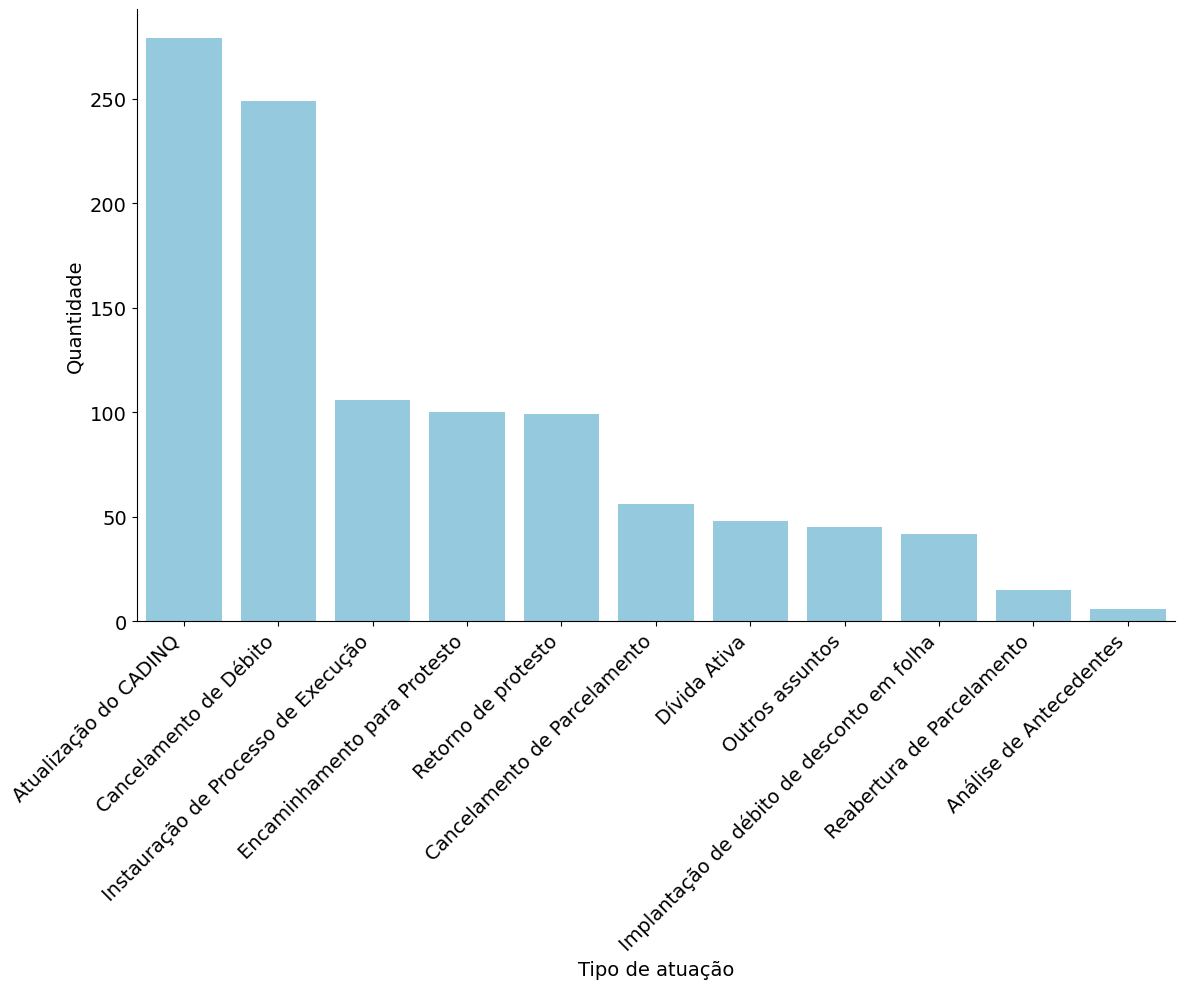

In [65]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=assuntos_ccd,
    x="descricao_objeto",
    y="count",
    color="skyblue"
)
ax.set_title("", fontsize=22)
ax.set_xlabel("Tipo de atuação", fontsize=14)
ax.set_ylabel("Quantidade", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
assuntos_ccd = tab_ccd['descricao_objeto'].value_counts().reset_index()

In [29]:
assuntos_ccd['descricao_objeto'].value_counts() 

descricao_objeto
Atualização do CADINQ                                                                        1
Cancelamento de Débito                                                                       1
Instauração de Processo de Execução                                                          1
Encaminhamento para Protesto                                                                 1
Retorno de protesto                                                                          1
Cancelamento de Parcelamento                                                                 1
Outros assuntos                                                                              1
Implantação de débito de desconto em folha                                                   1
Baixa de responsabilidade por prescrição                                                     1
Encaminhamento ao Ministério Público                                                         1
Reabertura de Parcelamento       

In [24]:
assuntos_ccd['descricao_objeto'] = assuntos_ccd['descricao_objeto'].apply(lambda x: x.replace('"', '').replace('*','').strip())
assuntos_ccd['descricao_objeto'] = assuntos_ccd['descricao_objeto'].apply(lambda x: 'Outros assuntos' if 'Outros assuntos' in x or 'Por favor' in x else x)

In [25]:
assuntos_ccd['descricao_objeto'].value_counts() 

descricao_objeto
Outros assuntos                                                                              44
Atualização do CADINQ                                                                         5
Instauração de Processo de Execução                                                           2
Cancelamento de Débito                                                                        2
Implantação de débito de desconto em folha                                                    2
Cancelamento de Parcelamento                                                                  2
Retorno de protesto                                                                           1
Encaminhamento para Protesto                                                                  1
Baixa de responsabilidade por prescrição                                                      1
Encaminhamento ao Ministério Público                                                          1
Encaminhamento ao Minis

In [26]:
len(assuntos)

67

In [30]:
processos_busca = ', '.join(f"'{proc}'" for proc in tab_ccd['processo'])
sql_tipo_processo = f'''
SELECT CONCAT(numero_processo, '/', ano_processo) as processo, codigo_tipo_processo, data_registro
FROM processo.dbo.Processos
WHERE CONCAT(numero_processo, '/', ano_processo) IN ({processos_busca})
'''
print(sql_tipo_processo)
sql_tipo_processo = sql_tipo_processo.format(processos_busca=processos_busca)
tipo_processo = pd.read_sql(sql_tipo_processo, conn)
#tab_ccd['tipo_processo'] = tipo_processo['codigo_tipo_processo'].values
#tab_ccd['tipo_processo'] = tab_ccd['tipo_processo'].fillna('')


SELECT CONCAT(numero_processo, '/', ano_processo) as processo, codigo_tipo_processo, data_registro
FROM processo.dbo.Processos
WHERE CONCAT(numero_processo, '/', ano_processo) IN ('301654/2025', '005217/2009', '001511/2024', '003649/2017', '003649/2017', '003649/2017', '010387/2013', '006248/2016', '001463/2023', '002619/2024', '002587/2024', '002571/2024', '001443/2023', '001443/2023', '002004/2024', '002032/2024', '000414/2024', '002033/2024', '002013/2025', '004923/2024', '002035/2024', '000065/2025', '000062/2025', '000067/2025', '003368/2024', '004871/2024', '003413/2024', '004871/2024', '011032/2016', '000060/2025', '000852/2025', '004887/2024', '003400/2024', '004923/2024', '000065/2025', '003413/2024', '002033/2024', '000852/2025', '000060/2025', '000852/2025', '000852/2025', '000852/2025', '002033/2024', '003368/2024', '002035/2024', '000067/2025', '000062/2025', '000060/2025', '004887/2024', '004871/2024', '004871/2024', '002013/2025', '004315/2019', '003154/2017', '701236/2

/tmp/ipykernel_12806/3166842054.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tipo_processo = pd.read_sql(sql_tipo_processo, conn)


3      11/05/2017
4      11/05/2017
5      11/05/2017
6      19/07/2013
8      27/09/2023
          ...    
784    29/05/2025
785    29/05/2025
786    29/05/2025
787    29/05/2025
788    13/05/2025
Name: data_recebimento, Length: 619, dtype: object

/tmp/ipykernel_17908/2871917385.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_processos_execucao = pd.read_sql(sql_processos_execucao, conn)


In [35]:
df_processos_execucao.sort_values(by='datainclusao')

,processo,datainclusao
26,003343/2017,02/04/2025
21,000671/2016,02/04/2025
39,012015/2015,03/04/2025
6,007405/2019,03/04/2025
0,003154/2017,08/05/2025
...,...,...
46,017028/2017,29/05/2025
2,014050/2017,29/05/2025
69,001150/2021,29/05/2025
36,015433/2017,29/05/2025


,processo,jurisdicionado,relator,data_recebimento,data_saida,descricao_objeto,descricao_encaminhamento
108,003343/2017,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,ANTONIO GILBERTO DE OLIVEIRA JALES,02/04/2025,15/04/2025,Instauração de Processo de Execução,NaN
106,000671/2016,TRIBUNAL DE CONTAS DO ESTADO,GEORGE MONTENEGRO SOARES,02/04/2025,15/04/2025,Instauração de Processo de Execução,NaN
105,007405/2019,CÂMARA MUNICIPAL DE ÁGUA NOVA,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,03/04/2025,15/04/2025,Instauração de Processo de Execução,NaN
107,012015/2015,EMPRESA POTIGUAR DE PROMOÇÃO TURISTICA S/A,ANTONIO ED SOUZA SANTANA,03/04/2025,15/04/2025,Instauração de Processo de Execução,NaN
52,004315/2019,CÂMARA MUNICIPAL DE SERRA CAIADA,ANA PAULA DE OLIVEIRA GOMES,08/05/2025,08/05/2025,Instauração de Processo de Execução,NaN
...,...,...,...,...,...,...,...
457,015433/2017,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,PAULO ROBERTO CHAVES ALVES,29/05/2025,29/05/2025,Instauração de Processo de Execução,NaN
773,006683/2019,CÂMARA MUNICIPAL DE ALEXANDRIA,ANTONIO ED SOUZA SANTANA,29/05/2025,NaN,Instauração de Processo de Execução,NaN
459,008581/2017,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,PAULO ROBERTO CHAVES ALVES,29/05/2025,29/05/2025,Instauração de Processo de Execução,NaN
783,006248/2016,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,PAULO ROBERTO CHAVES ALVES,29/05/2025,NaN,Instauração de Processo de Execução,NaN


In [1]:
setor = 'CIP'
ano = 2025
meses = [4, 5]
filename = 'saidas/sisdgf/processos_ccd.xlsx'

In [6]:
sql_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE setor = '{setor}'
and year(inf.data_resumo) = {ano}
and month(inf.data_resumo) IN ({', '.join(map(str, meses))})
'''
informacoes_processos = pd.read_sql(sql_informacoes_processos, conn)
informacoes_processos['caminho_arquivo'] = informacoes_processos.apply(get_file_path, axis=1)

informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Pagamento da parcela')]
informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Capa')]
informacoes_processos = informacoes_processos[~informacoes_processos['resumo'].str.contains('Evento do Processo Original')]

informacoes_setor = informacoes_processos[informacoes_processos['setor'].str.strip() == setor]
informacoes_setor['resumo'].fillna('', inplace=True)
informacoes_setor = informacoes_setor[~informacoes_setor['resumo'].str.contains('Pagamento da parcela')]
informacoes_setor['texto'] = informacoes_setor['caminho_arquivo'].apply(extract_text_from_pdf)
processos_busca = ', '.join(f"'{proc}'" for proc in informacoes_setor['processo'].unique())


/tmp/ipykernel_29134/876657161.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  informacoes_processos = pd.read_sql(sql_informacoes_processos, conn)


In [7]:
sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_file_path, axis=1)

/tmp/ipykernel_29134/3694876359.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [80]:
def get_informacao_ementa_resumo(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa informações de processos do Tribunal de Contas do Estado do Rio Grande do Norte.
        As informações possuem ementas. Após a ementa, há um resumo do texto.
        O resumo são 4 ou 3 parágrafos ou linhas, logo após a ementa.
                                              
        O resumo fica entre a ementa e o texto da informação, 
        
        O texto da informação inicia com INFORMAÇÃO e deve ser ignorado.                                      

        Sua tarefa é extrair o resumo que fica após a ementa da informação e até o início do texto da informação.                                       

        O texto da informação é o seguinte:
        "{input}"
                                              
        Somente extraia o texto, não modifique ou adicione nada.
        Se não houver ementa ou resumo, responda "Nenhum resumo encontrado".
        Separe o resumo por parágrafos, se houver mais de um, com \n (quebra de linha) entre eles.                                              
        
        Sua resposta:
        """)
        
        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None

In [82]:
informacoes_setor['descricao_objeto'] = informacoes_setor.apply(lambda row: get_descricao_informacao_conclusiva(row), axis=1)

In [83]:
informacoes_setor['resumo_pos_ementa'] = informacoes_setor['descricao_objeto']

In [84]:
informacoes_setor['descricao_objeto'] = informacoes_setor['resumo_pos_ementa'].apply(lambda x: x.split('\n')[0])
informacoes_setor['encaminhamento'] = informacoes_setor['resumo_pos_ementa'].apply(lambda x: x.split('\n')[-1])

In [85]:
informacoes_setor[['processo', 'descricao_objeto', 'encaminhamento']]

,processo,descricao_objeto,encaminhamento
0,000760/2025,Informação Instrutiva,Informação Instrutiva
1,001795/2024,Informação Instrutiva,Informação Instrutiva
2,002202/2023,Informação Instrutiva,Informação Instrutiva
3,000358/2024,1. Irregularidades apontadas: (i) Ausência de ...,4. Conclusão: (i) Rejeição das alegações de de...
4,003119/2021,Informação instrutiva.,Informação instrutiva.
...,...,...,...
87,002322/2024,Informação Instrutiva,Informação Instrutiva
88,005354/2024,Termo de Apensamento,Termo de Apensamento
89,017609/2016,Irregularidades apontadas: (i) Fixação e pagam...,Exame Técnico: (i) A apresentação de nova lei ...
90,005114/2021,1. Irregularidades identificadas: A DAM consta...,"4. Conclusão: Diante da omissão, da ausência d..."


In [21]:
info_instrutiva = informacoes_setor[informacoes_setor['Titulo_Modelo_informacao'] == 'Informação Instrutiva']
defesa = informacoes_setor[informacoes_setor['Titulo_Modelo_informacao'] == 'defesa']
info_conclusiva = informacoes_setor[informacoes_setor['Titulo_Modelo_informacao'] == 'Informação Conclusiva']
info_encaminhamento = informacoes_setor[informacoes_setor['Titulo_Modelo_informacao'] == 'Instrução de encaminhamento']
recurso = informacoes_setor[informacoes_setor['Titulo_Modelo_informacao'] == 'Recurso']
apensamento = informacoes_setor[informacoes_setor['Titulo_Modelo_informacao'] == 'Processo_apensamento_TCE.doc']

In [91]:
df_teste = defesa[:2]

In [92]:
df_teste.apply(get_descricao_cip, axis=1)

,arquivo,evento,processo,setor,numero_processo,ano_processo,ordem,data_resumo,resumo,sigilo,...,DataInformacaoSubstituida,IdTipoParecer,Observacao,IdProcesso,E_Relatorio_Inicial,E_Relatorio_Auditoria,caminho_arquivo,texto,descricao_objeto,encaminhamento
3,CIP_000358_2024_0041.pdf,66,000358/2024,CIP,000358,2024,41,2025-04-02 10:19:10.427,DENÚNCIA. PREFEITURA MUNICIPAL DE AFONSO BEZER...,None,...,NaT,None,None,None,None,None,/media/informacoes_pdf/CIP/CIP_000358_2024_004...,\n \n \nDiretoria de Instrução Processual e C...,Irregularidades apontadas: (i) Ausência de est...,Conclusão: (i) Rejeição das alegações de defes...
5,CIP_000406_2019_0037.pdf,68,000406/2019,CIP,000406,2019,37,2025-04-02 21:06:15.523,EMENTA. GESTÃO FISCAL MUNICIPAL. PREFEITURA DE...,None,...,NaT,None,None,None,None,None,/media/informacoes_pdf/CIP/CIP_000406_2019_003...,\n \n \nDiretoria de Instrução Processual e C...,Irregularidades apontadas: (i) Superestimação ...,Encaminhamento: Sugere-se o acolhimento parcia...


In [93]:
df_teste

,arquivo,evento,processo,setor,numero_processo,ano_processo,ordem,data_resumo,resumo,sigilo,...,IdInformacaoSubstituida,UsuarioInformacaoSubstituida,DataInformacaoSubstituida,IdTipoParecer,Observacao,IdProcesso,E_Relatorio_Inicial,E_Relatorio_Auditoria,caminho_arquivo,texto
3,CIP_000358_2024_0041.pdf,66,000358/2024,CIP,000358,2024,41,2025-04-02 10:19:10.427,DENÚNCIA. PREFEITURA MUNICIPAL DE AFONSO BEZER...,None,...,NaN,None,NaT,None,None,None,None,None,/media/informacoes_pdf/CIP/CIP_000358_2024_004...,\n \n \nDiretoria de Instrução Processual e C...
5,CIP_000406_2019_0037.pdf,68,000406/2019,CIP,000406,2019,37,2025-04-02 21:06:15.523,EMENTA. GESTÃO FISCAL MUNICIPAL. PREFEITURA DE...,None,...,NaN,None,NaT,None,None,None,None,None,/media/informacoes_pdf/CIP/CIP_000406_2019_003...,\n \n \nDiretoria de Instrução Processual e C...


In [96]:
defesa['teste'] = ''

/tmp/ipykernel_29134/2507020020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defesa['teste'] = ''


In [97]:
defesa['teste'] 

3     
5     
7     
10    
19    
29    
31    
32    
33    
34    
36    
37    
38    
46    
47    
48    
56    
57    
58    
59    
60    
61    
63    
66    
67    
69    
71    
78    
79    
80    
82    
83    
84    
89    
90    
91    
Name: teste, dtype: object